In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix


In [26]:
df = pd.read_pickle("../data/reviews_vector.pkl")

In [31]:
df[:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 504 entries, overall to your
dtypes: float64(501), int64(2), object(1)
memory usage: 39.5+ KB


In [28]:
[df.columns[:3],df.columns[4:]]

[Index(['overall', 'reviewText', 'length'], dtype='object'),
 Index(['10', '100', '6s', 'abl', 'absolut', 'access', 'actual', 'ad', 'adapt',
        'add',
        ...
        'wont', 'work', 'worri', 'worth', 'would', 'wouldnt', 'wrong', 'year',
        'yet', 'your'],
       dtype='object', length=500)]

In [32]:
minority_count = df[df['binary'] == 0].shape[0]
# random sample of majority class
majority_sample = df[df['binary'] == 1].sample(n=minority_count, random_state=42)

# merge to make balanced dataset
balanced_df = pd.concat([df[df['binary'] == 0], majority_sample])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [57]:
y_prime = balanced_df["binary"]

In [58]:
y_prime.value_counts()

binary
1    185626
0    185626
Name: count, dtype: int64

In [59]:
X=df[df.columns[4:]]
y=df["binary"]
X_prime = balanced_df[balanced_df.columns[4:]]


In [61]:
y.value_counts(), y_prime.value_counts()

(binary
 1    704818
 0    185626
 Name: count, dtype: int64,
 binary
 1    185626
 0    185626
 Name: count, dtype: int64)

Natural distribution vs downsampling the majority class

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [76]:
X_train_prime, X_test_prime, y_train_prime, y_test_prime = train_test_split(X_prime, y_prime, test_size=0.2, stratify=y_prime, random_state=42)

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [78]:
scaler_prime = StandardScaler()
scaler_prime.fit(X_train_prime)
X_train_transformed_prime = scaler.transform(X_train_prime)
X_test_transformed_prime = scaler.transform(X_test_prime)

In [ ]:
# testing for C value
penalties = [0.1, 1, 10, 100]

cvs1=[]

for c in penalties:
    # change depth each time
    estimators = [('normalise', StandardScaler()),
                ('model', LogisticRegression(C=c,penalty='l1', solver='liblinear',random_state=42))]
    pipe = Pipeline(estimators,verbose=True)
    # fitting
    pipe.fit(X_train, y_train)
    cvs =cross_val_score(pipe, X_train, y_train, cv=5).mean()
    cvs1.append(cvs)
    print(f"penalty: {c} Cross Validation accuracy: {cvs}")

In [25]:
cvs1

[0.8684869201451523, 0.8684883239396088, 0.8684911315285216, 0.868492535322978]

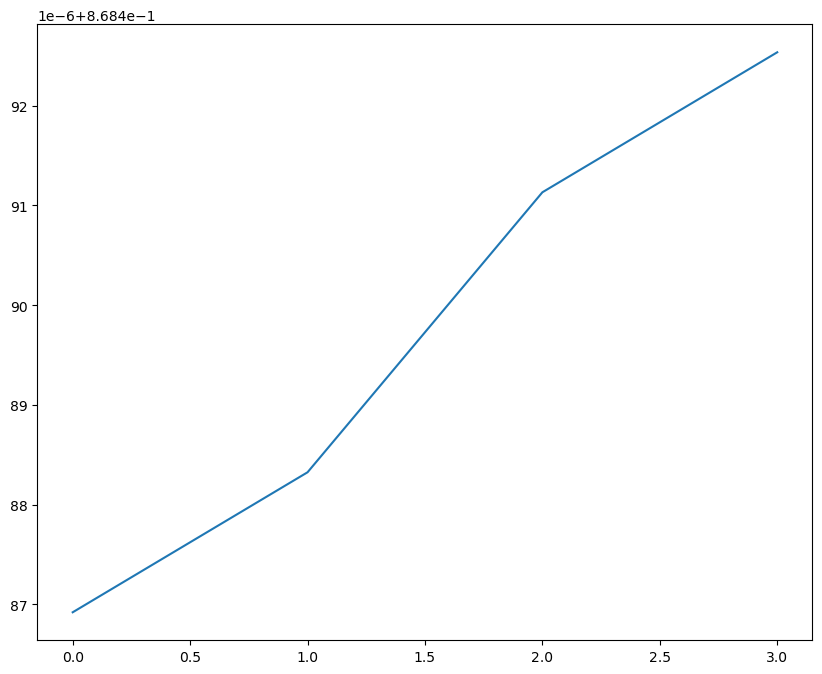

In [28]:
plt.figure(figsize=(10,8))
plt.plot(cvs1)

plt.show();

In [79]:


estimators = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators,verbose=True)
pipe_final_prime = Pipeline(estimators,verbose=True)

In [80]:
pipe_final.fit(X_train, y_train)


[Pipeline] ......... (step 1 of 2) Processing normalise, total=   3.8s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.7min


Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [81]:
pipe_final_prime.fit(X_train_prime, y_train_prime)


[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=  12.8s


Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [82]:
log_clas = pipe_final[-1]
log_clas_prime = pipe_final_prime[-1]



In [84]:
log_clas

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')

In [89]:
log_clas.score(X_train_transformed, y_train), log_clas.score(X_train_transformed_prime, y_train_prime)

(0.7305374427076388, 0.7986538765862741)

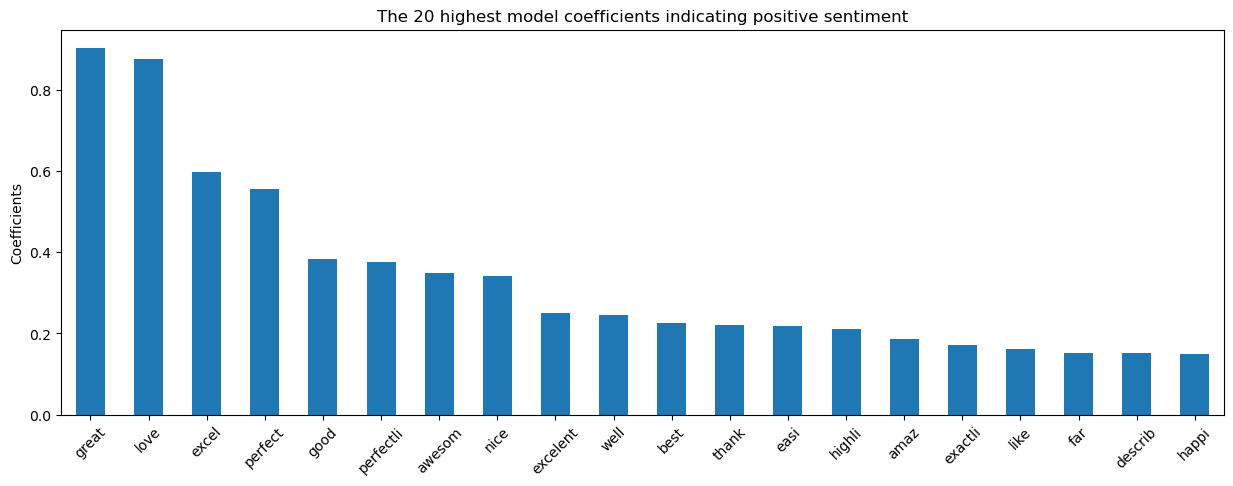

In [90]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=X_train.columns
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

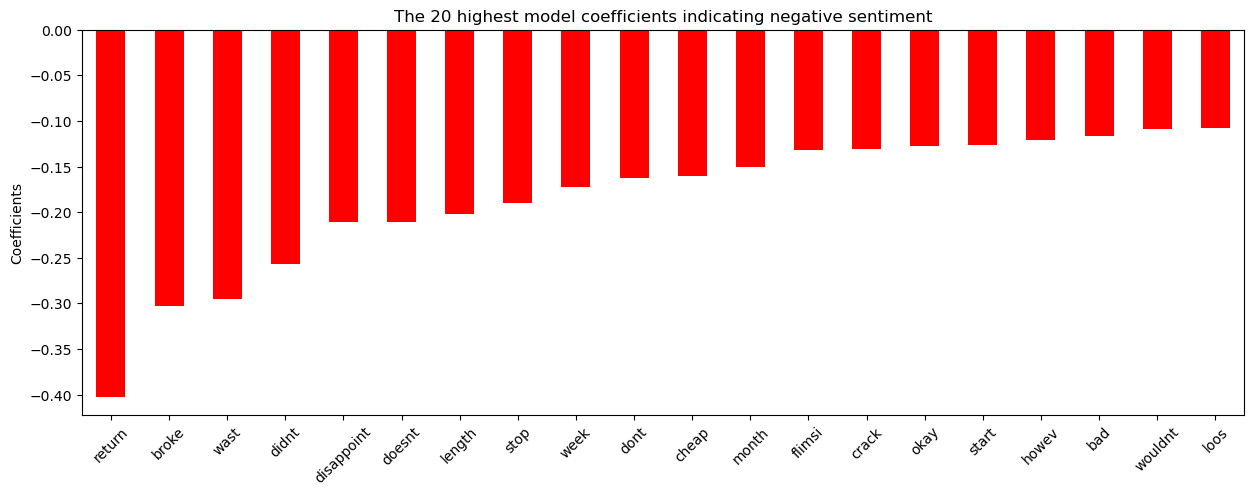

In [91]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=X_train.columns
).sort_values("coefficients", ascending=True)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [92]:
print(f"Train score: {log_clas.score(X_train_transformed, y_train)}")
print(f"Test score: {log_clas.score(X_test_transformed, y_test)}")


Train score: 0.7305374427076388
Test score: 0.7306627585083862


In [93]:
y_pred_baseline_test= log_clas.predict(X_test_transformed)

cm = confusion_matrix(y_test, y_pred_baseline_test, normalize="true")
cm_count = confusion_matrix(y_test, y_pred_baseline_test)

In [94]:
y_pred_baseline_test_prime= log_clas_prime.predict(X_test_transformed_prime)
cm_prime = confusion_matrix(y_test_prime, y_pred_baseline_test_prime, normalize="true")
cm_prime_count = confusion_matrix(y_test_prime, y_pred_baseline_test_prime)

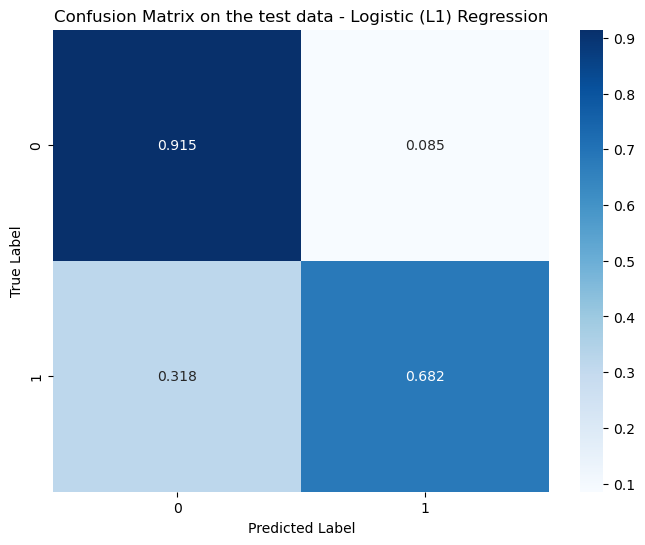

In [95]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test data - Logistic (L1) Regression")
plt.show()

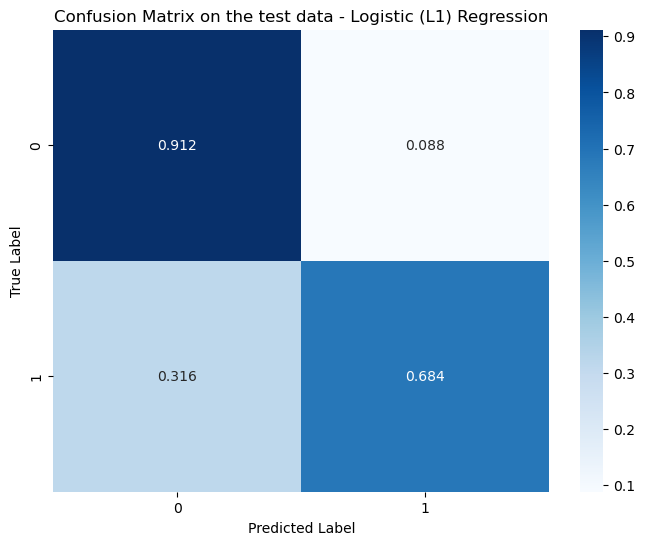

In [96]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_prime, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test data - Logistic (L1) Regression")
plt.show()

In [20]:
y_pred_baseline= log_clas.predict(scaler.transform(df[df.columns[4:]]))


In [24]:
incorrect_guesses = df["binary"] != y_pred_baseline
incorrect_v = pd.Series(y_pred_baseline)[incorrect_guesses]
pd.concat([pd.Series(incorrect_v),df[incorrect_guesses]], axis=1)


,0,overall,reviewText,length,binary,10,100,6s,abl,absolut,...,wont,work,worri,worth,would,wouldnt,wrong,year,yet,your
2,1,3.0,"so the case came on time, i love the design. I...",257,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.206035,0.0
16,1,2.0,I used this case for not even a week and the b...,118,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.242109,0.0,0.0,0.0,0.000000,0.0
58,0,4.0,The case is pretty and looks closely to the on...,434,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
64,1,3.0,The idea of the design is a sweet idea but it ...,216,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
66,1,3.0,"Pretty, but not as bright and vivid as in the ...",299,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890411,1,1.0,"I've purchased a pack of 3, all worked fine fo...",145,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.196856,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
890414,1,1.0,The cables eventually fail delivering a charge...,236,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
890415,0,5.0,Didn't think I would like it because I'm use t...,132,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.187573,0.0,0.0,0.0,0.000000,0.0
890436,1,1.0,The glass screen was smashed when it arrived.,45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
